# How to select the qubit subset to run your circuit on HW

The `BackendEvaluator` util allows you to find the best subset of qubits of a given **geometry** according to a given **metric**. This is useful to define the initial layout for the circuit transpilation to run on hardware.


## 1. Running with default settings

By default, the `BackendEvaluator` class will try to find the line (geometry) witht the best 2-qubit gate fidelity (metric) for a given backend. Let's see this in action for 10 qubits in a fake 16-qubit backend.

In [1]:
# SIMULATED FAKE BACKEND
from qiskit_ibm_runtime.fake_provider import FakeGuadalupe

backend = FakeGuadalupe()

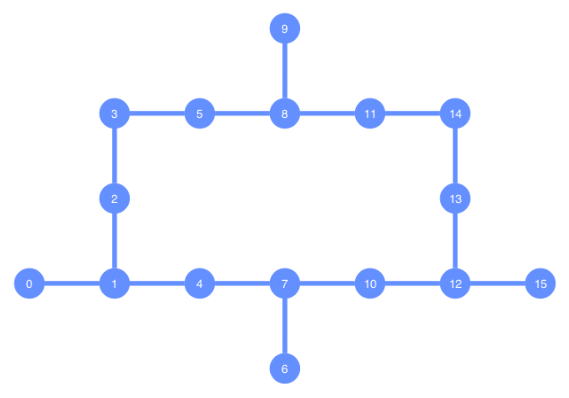

In [2]:
from qiskit.visualization import plot_gate_map

plot_gate_map(backend)

In [3]:
from qopt_best_practices.qubit_selection import BackendEvaluator

num_qubits = 10
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)

print("Best path: ", path)
print("Best path fidelity", fidelity)
print("Num. evaluated paths", num_subsets)

Best path:  [1, 4, 7, 10, 12, 13, 14, 11, 8, 5]
Best path fidelity 0.9099375156097996
Num. evaluated paths 20


## 2. Running with custom evaluation criteria

The evaluation criteria can also be defined by the user and given to the `BackendEvaluator` class as a callable:


In [4]:
from __future__ import annotations
import numpy as np
import rustworkx as rx

from qiskit.transpiler import CouplingMap


def find_lines(length: int, backend, coupling_map: CouplingMap | None = None) -> list[int]:
    """Finds all possible lines of length `length` for a specific backend topology.

    This method can take quite some time to run on large devices since there
    are many paths.

    Returns:
        The found paths.
    """

    # might make sense to make backend the only input for simplicity
    if coupling_map is None:
        coupling_map = CouplingMap(backend.configuration().coupling_map)

    all_paths = rx.all_pairs_all_simple_paths(
        coupling_map.graph,
        min_depth=length,
        cutoff=length,
    ).values()

    paths = np.asarray(
        [
            (list(c), list(sorted(list(c))))
            for a in iter(all_paths)
            for b in iter(a)
            for c in iter(a[b])
        ]
    )

    # filter out duplicated paths
    _, unique_indices = np.unique(paths[:, 1], return_index=True, axis=0)
    paths = paths[:, 0][unique_indices].tolist()

    return paths

In [5]:
def evaluate_fidelity(path: list[int], backend, edges) -> float:
    """Evaluates fidelity on a given list of qubits based on the two-qubit gate error
    for a specific backend.

    Returns:
       Path fidelity.
    """

    two_qubit_fidelity = {}
    props = backend.properties()

    if "cx" in backend.configuration().basis_gates:
        gate_name = "cx"
    elif "ecr" in backend.configuration().basis_gates:
        gate_name = "ecr"
    else:
        raise ValueError("Could not identify two-qubit gate")

    for edge in edges:
        try:
            cx_error = props.gate_error(gate_name, edge)

        except:
            cx_error = props.gate_error(gate_name, edge[::-1])

        two_qubit_fidelity[tuple(edge)] = 1 - cx_error

    if not path or len(path) == 1:
        return 0.0

    fidelity = 1.0
    for idx in range(len(path) - 1):
        fidelity *= two_qubit_fidelity[(path[idx], path[idx + 1])]

    return fidelity

In [6]:
num_qubits = 10
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(
    num_qubits, subset_finder=find_lines, metric_eval=evaluate_fidelity
)

print("Best path: ", path)
print("Best path fidelity", fidelity)
print("Num. evaluated paths", num_subsets)


Best path:  [1, 4, 7, 10, 12, 13, 14, 11, 8, 5]
Best path fidelity 0.9099375156097996
Num. evaluated paths 20
